# Cronenbot Extrator


## Importing Dependences

In [1]:
import json
import os
import numpy as np
import tensorflow as tf
import random
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras import layers
from keras.regularizers import l2

## Loading paths

In [2]:
train_data = []
trainset_path = '../../dstc8-schema-guided-dialogue/train/'
for file in os.listdir(trainset_path):
    if file != 'schema.json':
        with open(os.path.join(trainset_path, file), 'r') as json_file:
            for elem in json.load(json_file):
                train_data.append(elem)

In [3]:
test_data = []
testset_path = '../../dstc8-schema-guided-dialogue/test/'
for file in os.listdir(testset_path):
    if file != 'schema.json':
        with open(os.path.join(testset_path, file), 'r') as json_file:
            for elem in json.load(json_file):
                test_data.append(elem)

## Encoding Labels

In [4]:
labels = ["o", "title", "genre", "subtitles", "directed_by"]

def slot2label(slot):
  if slot == "title":
    return 2
  elif slot == "genre":
    return 3
  elif slot == "subtitles":
    return 4
  elif slot == "directed_by":
    return 5
  else:
    return 1

## Loading data and labeling

In [5]:
train_labels = []
test_labels = []
train_sentences = []
test_sentences = []

for dialogue in train_data:
    for idx in range(0, len(dialogue['turns']), 2):
        sentence = dialogue['turns'][idx]['utterance']
        labels = np.ones(len(sentence))
        slots = dialogue['turns'][idx]['frames'][0]['slots']

        for slot in slots:
          if slot2label(slot['slot']) != 1:
            labels = np.concatenate([labels[:slot['start']], np.array([slot2label(slot['slot'])]*(slot['exclusive_end']-slot['start'])), labels[slot['exclusive_end']:]])
            
            train_sentences.append(sentence)
            train_labels.append(labels);
        
for dialogue in test_data:
    for idx in range(0, len(dialogue['turns']), 2):
        sentence = dialogue['turns'][idx]['utterance']
        labels = np.ones(len(sentence))
        slots = dialogue['turns'][idx]['frames'][0]['slots']

        for slot in slots:
          if slot2label(slot['slot']) != 1:
            labels = np.concatenate([labels[:slot['start']], np.array([slot2label(slot['slot'])]*(slot['exclusive_end']-slot['start'])), labels[slot['exclusive_end']:]])
          
            test_sentences.append(sentence)
            test_labels.append(labels);

## Creating vocab and mapping

In [6]:
# create character vocab
all_text = " ".join([" ".join(x) for x in train_sentences+test_sentences])
vocab = sorted(set(all_text))

# create character/id and label/id mapping
char2idx = {u:i+1 for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

print(char2idx)

train_sentences = list(map(lambda s:list(map(lambda c: char2idx[c],s)),train_sentences))
test_sentences = list(map(lambda s:list(map(lambda c: char2idx[c],s)),test_sentences))

{' ': 1, '!': 2, '&': 3, "'": 4, ',': 5, '-': 6, '.': 7, '/': 8, '0': 9, '1': 10, '2': 11, '3': 12, '4': 13, '5': 14, '6': 15, '7': 16, '8': 17, '9': 18, ':': 19, ';': 20, '>': 21, '?': 22, 'A': 23, 'B': 24, 'C': 25, 'D': 26, 'E': 27, 'F': 28, 'G': 29, 'H': 30, 'I': 31, 'J': 32, 'K': 33, 'L': 34, 'M': 35, 'N': 36, 'O': 37, 'P': 38, 'Q': 39, 'R': 40, 'S': 41, 'T': 42, 'U': 43, 'V': 44, 'W': 45, 'X': 46, 'Y': 47, 'Z': 48, 'a': 49, 'b': 50, 'c': 51, 'd': 52, 'e': 53, 'f': 54, 'g': 55, 'h': 56, 'i': 57, 'j': 58, 'k': 59, 'l': 60, 'm': 61, 'n': 62, 'o': 63, 'p': 64, 'q': 65, 'r': 66, 's': 67, 't': 68, 'u': 69, 'v': 70, 'w': 71, 'x': 72, 'y': 73, 'z': 74}


## Creating generators for training

In [7]:

def gen_train_series():

    for eg in zip(train_sentences, train_labels):
      yield eg[0],eg[1]

def gen_valid_series():

    for eg in valid_formatted:
      yield eg[0],eg[1]

def gen_test_series():

  for eg in zip(test_sentences, test_labels):
      yield eg[0],eg[1]
  
series = tf.data.Dataset.from_generator(gen_train_series,output_types=(tf.int32, tf.int32),output_shapes = ((None, None)))
series_test = tf.data.Dataset.from_generator(gen_test_series,output_types=(tf.int32, tf.int32),output_shapes = ((None, None)))

BATCH_SIZE = 128
BUFFER_SIZE=1000

ds_series_batch = series.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE, padded_shapes=([None], [None]), drop_remainder=True)
ds_series_batch_test = series_test.padded_batch(BATCH_SIZE, padded_shapes=([None], [None]), drop_remainder=True)




## Defining Model

In [8]:

vocab_size = len(vocab)+1

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

label_size = len(labels)  

# build LSTM model
def build_model(vocab_size,label_size, embedding_dim, rnn_units, batch_size):
      model = tf.keras.Sequential([
          tf.keras.layers.Embedding(vocab_size, embedding_dim,
                            batch_input_shape=[batch_size, None],mask_zero=True),
          tf.keras.layers.LSTM(rnn_units,
                      return_sequences=True,
                      stateful=True,
                      recurrent_initializer='glorot_uniform'),
          tf.keras.layers.Dense(label_size)
          ])
      return model

model = build_model(
      vocab_size = len(vocab)+1,
      label_size=len(labels)+1,
      embedding_dim=embedding_dim,
      rnn_units=rnn_units,
      batch_size=BATCH_SIZE)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (128, None, 256)          19200     
_________________________________________________________________
lstm (LSTM)                  (128, None, 1024)         5246976   
_________________________________________________________________
dense (Dense)                (128, None, 41)           42025     
Total params: 5,308,201
Trainable params: 5,308,201
Non-trainable params: 0
_________________________________________________________________


## Defining Loss and compiling

In [10]:
import os

# define loss function
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

model.compile(optimizer='adam', loss=loss,metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

## Training

In [13]:
    EPOCHS=100
    history = model.fit(ds_series_batch, epochs=EPOCHS, validation_data=ds_series_batch_test,callbacks=[checkpoint_callback])

Epoch 1/100
28/28 [==============================] - 3s 98ms/step - loss: 0.0407 - sparse_categorical_accuracy: 0.9540 - val_loss: 0.1382 - val_sparse_categorical_accuracy: 0.8999
Epoch 2/100
28/28 [==============================] - 2s 74ms/step - loss: 0.0407 - sparse_categorical_accuracy: 0.9539 - val_loss: 0.1391 - val_sparse_categorical_accuracy: 0.8958
Epoch 3/100
28/28 [==============================] - 2s 72ms/step - loss: 0.0401 - sparse_categorical_accuracy: 0.9553 - val_loss: 0.1361 - val_sparse_categorical_accuracy: 0.9008
Epoch 4/100
28/28 [==============================] - 2s 74ms/step - loss: 0.0409 - sparse_categorical_accuracy: 0.9544 - val_loss: 0.1392 - val_sparse_categorical_accuracy: 0.9018
Epoch 5/100
28/28 [==============================] - 2s 76ms/step - loss: 0.0382 - sparse_categorical_accuracy: 0.9552 - val_loss: 0.1416 - val_sparse_categorical_accuracy: 0.8960
Epoch 6/100
28/28 [==============================] - 2s 76ms/step - loss: 0.0370 - sparse_categorica

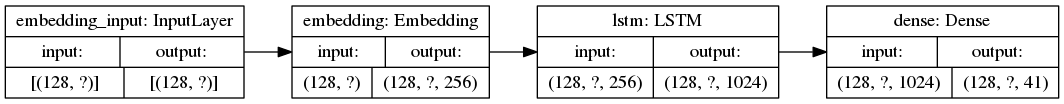

In [10]:
import pydot
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, rankdir='LR',show_layer_names=True)

## Saving

In [14]:

model.save('models/entities.h5')


## Others